In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
!python -m pip install -e .

/home/anna/hse/FewShotLearning
Obtaining file:///home/anna/hse/FewShotLearning
  Found existing installation: fewshot 0.0.1
    Uninstalling fewshot-0.0.1:
      Successfully uninstalled fewshot-0.0.1
  Running setup.py develop for fewshot


In [3]:
import fewshot

In [4]:
import os

dataset_root = 'fewshot/datasets'
dataset_name = 'mini_imagenet'
csv_name = 'data_84x84.csv'

dataset_dir = os.path.join(dataset_root, dataset_name)

Let's take a look at the data:

In [5]:
import pandas as pd

dataframe = pd.read_csv(os.path.join(dataset_dir, csv_name))
dataframe.head()

,filepath,class
0,images_84x84/n0153282900000005.jpg,n01532829
1,images_84x84/n0153282900000006.jpg,n01532829
2,images_84x84/n0153282900000007.jpg,n01532829
3,images_84x84/n0153282900000010.jpg,n01532829
4,images_84x84/n0153282900000014.jpg,n01532829


In [6]:
classes = dataframe['class'].unique()
print(len(classes))
print(' | '.join(classes))

100
n01532829 | n01558993 | n01704323 | n01749939 | n01770081 | n01843383 | n01855672 | n01910747 | n01930112 | n01981276 | n02074367 | n02089867 | n02091244 | n02091831 | n02099601 | n02101006 | n02105505 | n02108089 | n02108551 | n02108915 | n02110063 | n02110341 | n02111277 | n02113712 | n02114548 | n02116738 | n02120079 | n02129165 | n02138441 | n02165456 | n02174001 | n02219486 | n02443484 | n02457408 | n02606052 | n02687172 | n02747177 | n02795169 | n02823428 | n02871525 | n02950826 | n02966193 | n02971356 | n02981792 | n03017168 | n03047690 | n03062245 | n03075370 | n03127925 | n03146219 | n03207743 | n03220513 | n03272010 | n03337140 | n03347037 | n03400231 | n03417042 | n03476684 | n03527444 | n03535780 | n03544143 | n03584254 | n03676483 | n03770439 | n03773504 | n03775546 | n03838899 | n03854065 | n03888605 | n03908618 | n03924679 | n03980874 | n03998194 | n04067472 | n04146614 | n04149813 | n04243546 | n04251144 | n04258138 | n04275548 | n04296562 | n04389033 | n04418357 | 

Visualization utils:

In [7]:
import matplotlib.pyplot as plt

def plot_batch(x, y, info=None):
    batch_size = len(x)
    annotations = []
    class_name = 'unknown'
    image_name = 'unknown'
    
    print('Batch specs: {} items, item size = {}, dtype = {}'.format(batch_size, x[0].shape, x[0].dtype))
    
    fig, ax = plt.subplots(ncols=batch_size, figsize=(6 * batch_size, 5))
    for index in range(batch_size):
        image = x[index].astype(int)
        if batch_size > 1:
            ax[index].imshow(image)
            ax[index].axis('off')
        else:
            ax.imshow(image)
            ax.axis('off')
            
        if info is not None:
            dataframe_index, class_name, image_name = info[index]
        
        annotation = r'#{} (sample №{}): IMG [{}] CLASS [{}]'.format(index, dataframe_index, image_name, class_name)
        annotations.append(annotation)
        
    print('\n'.join(annotations))
    plt.show()

## Dataset

Initialize common class for both of the operating modes -- batch and few-shot:

In [8]:
from fewshot.data_provider import Dataset
dataset = Dataset(dataset_dir=dataset_dir, csv_name=csv_name)

In [9]:
small_dataset, _ = dataset.split_by_objects(train_size=0.01)

Split by objects with train size = 0.01 (seed = 42)
Train data: 600 samples
Test data:  59400 samples


/home/anna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
train_dataset, test_dataset = small_dataset.split_by_classes()

Split by classes with train size = 0.5 (seed = 42)
Train classes: 50
Test classes: 50
Train data: 300 samples
Test data:  300 samples


## Pretraining stage

In [11]:
batch_generator = train_dataset.get_batch_generator(batch_size=4,
                                                    shuffle=True,
                                                    return_info=True)

In [12]:
def plot_multiple_batches(generator, num_batches=1):
    for batch_index in range(num_batches):
        print('Batch {}:'.format(batch_index + 1)) 
        plot_batch(*(next(generator)))

Batch 1:
Batch specs: 4 items, item size = (84, 84, 3), dtype = float32
#0 (sample №17502): IMG [images_84x84/n0216545600000224.jpg] CLASS [n02165456]
#1 (sample №12106): IMG [images_84x84/n0211006300000237.jpg] CLASS [n02110063]
#2 (sample №34306): IMG [images_84x84/n0347668400000238.jpg] CLASS [n03476684]
#3 (sample №2070): IMG [images_84x84/n0174993900000588.jpg] CLASS [n01749939]


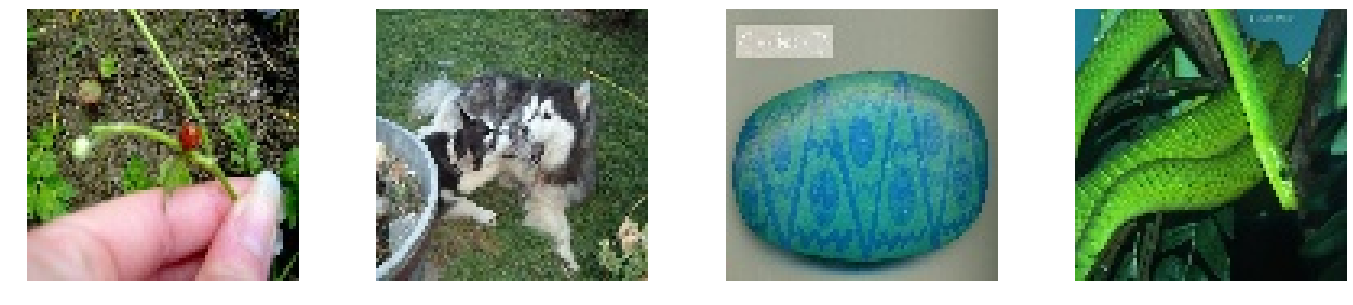

In [13]:
plot_multiple_batches(batch_generator)

In [14]:
from fewshot.algorithms.backbone_pretrain import simple_one_layer_cross_entropy_train
from fewshot.backbones import ConvNet

In [15]:
backbone = ConvNet(input_size=(84, 84, 3))
simple_one_layer_cross_entropy_train(
    backbone,
    train_dataset.get_batch_generator(batch_size=32, shuffle=True),
    validation_dataset=test_dataset.get_batch_generator(batch_size=32, shuffle=False)
)

Instructions for updating:
Colocations handled automatically by placer.
10/10 [==============================] - 8s 770ms/step - loss: 5.1024 - acc: 0.0233 - val_loss: 16.9164 - val_acc: 0.0300


## Few-shot stage

### 5-way 1-shot

In [16]:
n_way = 5
k_shot = 1
query_samples_per_class = 16
num_episodes = 2

In [17]:
from fewshot.algorithms.fewshot_models import BaselineFewShotModel
model = BaselineFewShotModel(backbone, n_way)

In [18]:
import numpy as np

Using batch generator:

In [19]:
for episode in range(num_episodes):
    random_state = np.random.randint(100000)
    fewshot_dataset, _ = dataset.split_by_classes(train_size=n_way) 
    fewshot_support_dataset, fewshot_dataset = fewshot_dataset.split_by_objects(train_size=n_way)
    fewshot_query_dataset, _ = fewshot_dataset.split_by_objects(train_size=query_samples_per_class)

    model.fit(fewshot_support_dataset.get_batch_generator(batch_size=1))
    print(model.predict(fewshot_query_dataset.get_batch_generator(batch_size=1)))

Split by classes with train size = 5 (seed = 42)
Train classes: 5
Test classes: 95
Train data: 3000 samples
Test data:  57000 samples
Split by objects with train size = 5 (seed = 42)
Train data: 25 samples
Test data:  2975 samples
Split by objects with train size = 16 (seed = 42)
Train data: 80 samples
Test data:  2895 samples
Instructions for updating:
Use tf.cast instead.
[[-0.15771317 -0.11836394 -0.16856222 -0.16315563 -0.18035215]
 [-0.16447751 -0.12609617 -0.16244929 -0.16855842 -0.17554937]
 [-0.17885295 -0.12503782 -0.17160673 -0.16922332 -0.14976843]
 [-0.14052287 -0.13930476 -0.16821681 -0.16275924 -0.16762577]
 [-0.16350165 -0.09421852 -0.18954162 -0.19961178 -0.15300441]
 [-0.15279563 -0.12541032 -0.17498627 -0.19064108 -0.15589549]
 [-0.15437952 -0.15574865 -0.13650255 -0.17963155 -0.16570023]
 [-0.13590951 -0.18083003 -0.1649627  -0.1218852  -0.16210727]
 [-0.1609645  -0.09108585 -0.12222424 -0.15750961 -0.23701751]
 [-0.13187805 -0.14140674 -0.1782529  -0.17613286 -0.164

Using few-shot generator:

In [20]:
for episode in range(num_episodes):
    random_state = np.random.randint(100000)
    fewshot_dataset, _ = dataset.split_by_classes(train_size=n_way, random_state=random_state)
    fewshot_generator = fewshot_dataset.get_fewshot_generator(k_shot=k_shot,
                                                              query_samples_per_class=query_samples_per_class,
                                                              shuffle=True)
    
    (x_support, y_support), (x_query, y_query) = next(fewshot_generator)
    print('Support set: {} samples'.format(len(x_support)))
    print('Query set:   {} samples'.format(len(x_query)))
    model.model.fit(x_support, y_support)
    print(model.model.predict(x_query))

Split by classes with train size = 5 (seed = 11586)
Train classes: 5
Test classes: 95
Train data: 3000 samples
Test data:  57000 samples
Support set: 5 samples
Query set:   80 samples
5/5 [==============================] - 0s 5ms/sample - loss: 1.6248 - acc: 0.2000
[[-0.13476129 -0.20544453 -0.19617213 -0.17090237 -0.11149888]
 [-0.01618536 -0.23104393 -0.12047034 -0.1884289  -0.09940618]
 [-0.13071088 -0.19877984 -0.20378834 -0.15868676 -0.10762413]
 [-0.16882135 -0.14327022 -0.17123404 -0.19785556 -0.14788778]
 [-0.21035933 -0.08086965 -0.16635893 -0.22711597 -0.15660751]
 [-0.18619491 -0.1309465  -0.1732861  -0.21231936 -0.13649364]
 [-0.15204497 -0.16927147 -0.16536912 -0.1428222  -0.1888582 ]
 [-0.18678683 -0.10206541 -0.16591635 -0.17716147 -0.1870874 ]
 [-0.16778877 -0.16050458 -0.18203686 -0.18556917 -0.148631  ]
 [-0.13098337 -0.16970181 -0.20273209 -0.18439715 -0.11414514]
 [-0.20339546 -0.18070142 -0.17681196 -0.13112286 -0.14529404]
 [-0.17587918 -0.12907852 -0.14504796 -0.